# Immersed Boundary Projection Method
---

### Author: Marin Lauber

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse, optimize, linalg
import NSsolver as ns
try:
    plt.style.use("jupyter")
except OSerror:
    print("Using default ploting style")

### Fractional Step 

The immersed boundary projection method [Tiara and Colonius (2007)](https://d1wqtxts1xzle7.cloudfront.net/31101693/TairaColonius2007.pdf?1365441675=&response-content-disposition=inline%3B+filename%3DThe_immersed_boundary_method_A_projectio.pdf&Expires=1594972583&Signature=evebVsqQ~CP0mGY3mZGnsXTBeMWPIBVtTN~S5asCJrNMWdfvP2wgukOgrqw~fnrYlBHo8zl72aZRCRYNGwSCVtmu3aiq5x~WMzaYIzeW-HIgddpp~S6tkWBoar-fJNXIAbkL2YWsOLfd2wqGi8Gn5Fig3oKh3itinuckPJ0p50e7zRITgVE~Bh1ZoKsQW1pfqAge1kSpMW35sr5hVKMQT8-mRMlnxecJrpy4Z~sbACR02YvbAIVlCWESq69xsAy6dtJWPp1QgRZrjbLwTMwRcPnFm50LDM68HDRXXAbN~-zEjczEvpKOuVbIF0MgLpDc7Vdx6H6Hzg9Fto9hMkLQJQ__&Key-Pair-Id=APKAJLOHF5GGSLRBV4ZA) is a new formulation of the immersed boundary method based on the fractional step algorithm. A boundary force is also added to the the incompressible Navier-Stokes equation. This method recognised that this boundary force can be seen as an additional Lagrange multiplier for the system (the first one being the pressure)

\begin{split}
    \frac{\partial \vec{u}}{\partial t} + (\vec{u}\cdot\nabla)\vec{u} &= -\nabla p + \frac{1}{Re}\nabla^2\vec{u} + \int\vec{f}(\vec{\xi}(s, t))\delta(\vec{\xi} - \vec{x}) \text{ d}\vec{x},\\
    \nabla\cdot\vec{u} &= 0,\\
    \vec{u}(\vec{\xi}(s, t)) &= \int_{\vec{x}}\vec{u}(\vec{x})\delta(\vec{x} - \vec{\xi} ) \text{ d}\vec{x} = \vec{u}_B(\vec{\xi}(s, t)).
\end{split}

which can be written in matrix form as

\begin{equation}
    \begin{bmatrix} A & G & -H \\\
    D & 0 & 0 \\\
    E & 0 & 0 \end{bmatrix}\begin{pmatrix} q^{n+1} \\\
    \phi \\\
    f \end{pmatrix} = \begin{pmatrix} r^{n} \\\
    0 \\\
    u_B^{n+1} \end{pmatrix} + \begin{pmatrix} bc_1 \\\
    bc_2 \\\
    0 \end{pmatrix}
\end{equation}

with the regularization ($H$) and interpolation ($E$) skewed-symetric operators. The gradient ($G$) and the divergence ($D$) matrix are chosen such that they are skewed-symmetrix such that the system can be rewritten to

\begin{equation}
    \begin{bmatrix} A & G & E^\top \\\
    G^\top & 0 & 0 \\\
    E & 0 & 0 \end{bmatrix}\begin{pmatrix} q^{n+1} \\\
    \phi \\\
    \tilde{f} \end{pmatrix} = \begin{pmatrix} r^{n} \\\
    0 \\\
    u_B^{n+1} \end{pmatrix} + \begin{pmatrix} bc_1 \\\
    -bc_2 \\\
    0 \end{pmatrix}
\end{equation}

with $\tilde{f}$ such that $Hf=-E^\top\tilde{f}$, let

\begin{equation}
    Q \equiv [G, E^\top], \qquad \lambda\equiv\begin{pmatrix}\phi\\\tilde{f}\end{pmatrix}, \qquad r_1 = r^n + bc_1, \qquad r_2 = \begin{pmatrix}-bc_2\\u_B^{n+1}\end{pmatrix}.
\end{equation}

which allows the previous system to be rewritten as

\begin{equation}
    \begin{bmatrix} A & Q \\\
    Q^\top & 0 \end{bmatrix}\begin{pmatrix} q^{n+1} \\\
   \lambda \end{pmatrix} = \begin{pmatrix} r_1 \\\
    r_2  \end{pmatrix}
\end{equation}

The LU decomposition of this system yields

\begin{equation}
    \begin{bmatrix} A & 0 \\\
    Q^\top & -Q^\top B^N Q \end{bmatrix}\begin{bmatrix} I & B^NQ \\\
    0 & I \end{bmatrix}\begin{pmatrix} q^{n+1} \\\
   \lambda \end{pmatrix} = \begin{pmatrix} r_1 \\\
    r_2  \end{pmatrix} + \begin{pmatrix} -\frac{\Delta t^N}{2^N}(LM^{-1})^{N}Q\lambda \\\
    0  \end{pmatrix}
\end{equation}

where $B^N$ is a $N^{th}$ order approximation to $A^{-1}$

\begin{equation}
    B^N \approx A^{-1} = \Delta t M^{-1} + \frac{\Delta t^2}{2}(M^{-1}L)M^{-1} + ...
\end{equation}

From this LU decomposition we get the following fractional step alorithm

\begin{split}
    Aq^* &= r_1\\
    Q^\top B^N Q \lambda &= Q^\top q^* - r_2\\
    q^{n+1} &= q^* - B^NQ\lambda
\end{split}

### Interpolation and regularization kernel

Interpolation and regularizatio is performed trough the discrete Dirac delta function

\begin{equation}
d(r) = \begin{cases}
    \frac{1}{6\Delta r}\left[ 5-3\frac{|r|}{\Delta r} -\sqrt{-3\left(1-\frac{|r|}{\Delta r}\right)^2 +1}\right] & \qquad \text{for  } 0.5\Delta r \le |r| \le 1.5\Delta r\\
    \frac{1}{3\Delta r}\left[ 1+\sqrt{-3\left(\frac{r}{\Delta r}\right)^2 +1}\right] & \qquad \text{for  } |r| \le 0.5\Delta r\\
    0 & \qquad \text{else}
       \end{cases}
\end{equation}

In [5]:
def kernel(r, dr=1):
    delta = np.where(abs(r)<=1.5*dr, np.where(abs(d)<=0.5*dr,
                                             1./(3.*dr)*(1.+np.sqrt(abs(-3*(r/dr)**2+1))),
                                             1./(6.*dr)*(5-3*(abs(r)/dr)-np.sqrt(abs(-3*(1-abs(r)/dr)**2+1)))),
                    0)
    return delta

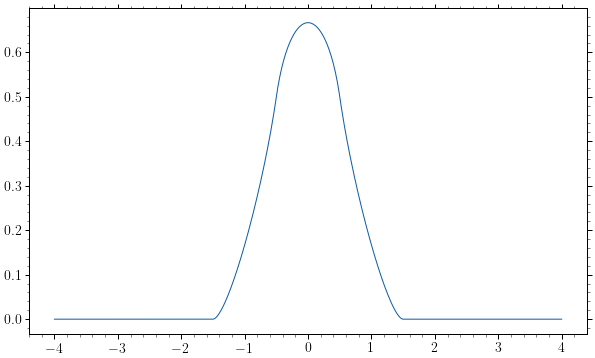

In [6]:
d = np.linspace(-4, 4, 512)
plt.plot(d, kernel(d));

Make a gradient matrix, we construct it such that is is related to the divergence matrix by

\begin{equation}
    D = -G^\top
\end{equation}

we can then check with the divergence and gradient from the NSsolver library.

In [7]:
def make_G_matrix(phi, dx=1):
    G =  sparse.diags([-1,1],[-1,0],shape=(len(phi), len(phi))).toarray()
    G[0,1]=0; G[0,-1]=-1
    return G*(1./dx)

In [8]:
t = np.arange(32)
G = make_G_matrix(t)
np.matmul(G, t)

array([-31.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
         1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
         1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.])

In [9]:
ns.grad(np.arange(32), dx=1)

array([-31.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
         1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
         1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.])

In [10]:
np.matmul(-G.T, t)

array([  1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
         1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
         1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1., -31.])

In [11]:
ns.div(t, dx=1)

array([  1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1, -31])

Do we actually get the Laplacian matrix when we do 
\begin{equation}
    L = -G^\top G
\end{equation}

In [12]:
x, dx  = np.linspace(0,1,32,retstep=True)
G = make_G_matrix(x, dx)
np.matmul(-G.T, G)

array([[-1922.,   961.,     0., ...,     0.,     0.,   961.],
       [  961., -1922.,   961., ...,     0.,     0.,     0.],
       [    0.,   961., -1922., ...,     0.,     0.,     0.],
       ...,
       [    0.,     0.,     0., ..., -1922.,   961.,     0.],
       [    0.,     0.,     0., ...,   961., -1922.,   961.],
       [  961.,     0.,     0., ...,     0.,   961., -1922.]])

In [13]:
ns.build_pressure_mat(np.ones_like(x), x, dx)

array([[-1922.,   961.,     0., ...,     0.,     0.,   961.],
       [  961., -1922.,   961., ...,     0.,     0.,     0.],
       [    0.,   961., -1922., ...,     0.,     0.,     0.],
       ...,
       [    0.,     0.,     0., ..., -1922.,   961.,     0.],
       [    0.,     0.,     0., ...,   961., -1922.,   961.],
       [  961.,     0.,     0., ...,     0.,   961., -1922.]])

How does the $Q^\top B^N Q$ matrix looks like? Writting it explicitely we have

\begin{equation}
\begin{bmatrix}G^\top \\\
E \end{bmatrix}\begin{bmatrix}G & E^\top \end{bmatrix}
\end{equation}

the gradient matrix for a staggered grid ($i^{th}$ vector located to the left of $i^{th}$ scalar)
is

\begin{equation}
G = \begin{bmatrix} 1 & 0 & 0 & 0 & 0 & 0 & 0 & -1 \\\
-1 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\\
0 & -1 & 1 & 0 & 0 & 0 & 0 & 0 \\\
0 & 0 & -1 & 1 & 0 & 0 & 0 & 0 \\\
0 & 0 & 0 & -1 & 1 & 0 & 0 & 0 \\\
0 & 0 & 0 & 0 & -1 & 1 & 0 & 0 \\\
0 & 0 & 0 & 0 & 0 & -1 & 1 & 0 \\\
0 & 0 & 0 & 0 & 0 & 0 & -1 & 1
 \end{bmatrix}
\end{equation}

and $E^\top is simply a transpose version of the kernel applied to the distance function on the mesh

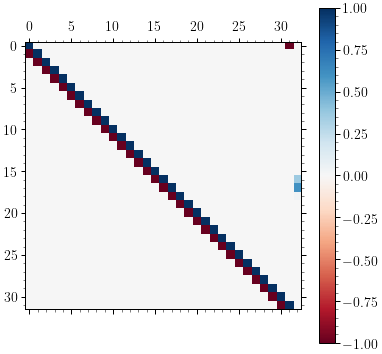

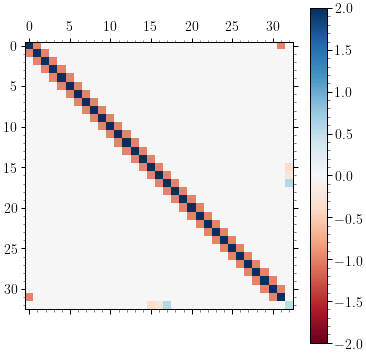

In [14]:
t = np.arange(32)
d = t-16.67
# np.newaxis is transpose for arrays
Q = np.hstack((make_G_matrix(t), kernel(d, 1)[:,np.newaxis]))
plt.matshow(Q, cmap='RdBu'); plt.colorbar();
QTQ = np.matmul(Q.T, Q)
plt.matshow(QTQ, cmap='RdBu', clim=(-2,2)); plt.colorbar();

### 1D Piston

Here an explicit update is used for the predicted velocity field, such that $A\equiv I$. This make $B^N\equiv I$ and the fractional step algorithm simplifies to

\begin{split}
    q^* &= r_1\\
    Q^\top Q \lambda &= Q^\top q^* - r_2\\
    q^{n+1} &= q^* - Q\lambda
\end{split}

where $Q$ is a combination of $G$ and $E^\top$. Because the piston is a signle point, the zise of the matrix $Q$ compared to $G$ is only one row/column larger, making the system very easy to solve.

In [54]:
def update(d, u, V, dx, dt, kernel):
    
    # predict velocity 
    u_star = u + dt*ns.r(u, dx)
    
    # get source := [phi, \tilde{f}]^T
    sigma = ns.div(u_star, dx)
    q_star = np.hstack([sigma, V])
    
    # build pressure matrix [G, E^T] --> [G, E[:,np.newaxis]]
    Q = np.hstack([make_G_matrix(sigma, dx), kernel(d)[:,np.newaxis]])
    QTQ = np.matmul(-Q.T, Q)

    # solve, source has addition of interface velocity
    lam = ns.Jacobi(QTQ, q_star, tol=1e-10, verbose=True)

    # recover pressure and forcing
    p=lam[:-1]; f=lam[-1]

    # correct
    u_n = u_star - dt*(ns.grad(p, dx) + f*kernel(d))
    
    return p, u_n, f

In [55]:
N = 32
x, dx = np.linspace(-1, 1, N, retstep=True)
xs = x+0.5*dx
# random interface position
X = np.random.rand()*.1
V = 1
u0 = np.zeros_like(x)
dt = 1.
d = (x-X)/dx

p, u_n, f =  update(d, u0, V, dx, 1, kernel)
print("Interface at X: %.2f" % X)
print(r"L inf: %.3e" % np.max(np.abs(u_n -  V)))

Jacobi solver:
	res0: 3.030e-02
 	res: 3.015e-12
 	iter: 2584
Interface at X: 0.06
L inf: 1.487e-11


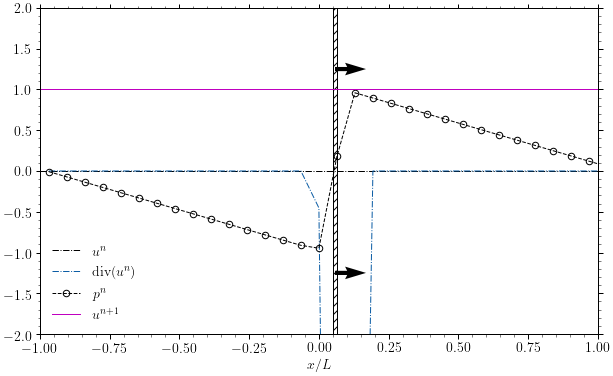

In [56]:
ns.draw_results(x, xs, X, u0, u_n, p, f*kernel(d))

### Change kernel and Repeat

In [57]:
def cosine(d, e=1):
    return np.where(abs(d)<e, 0.5*(1+np.cos(np.pi*d/e))/e, 0)

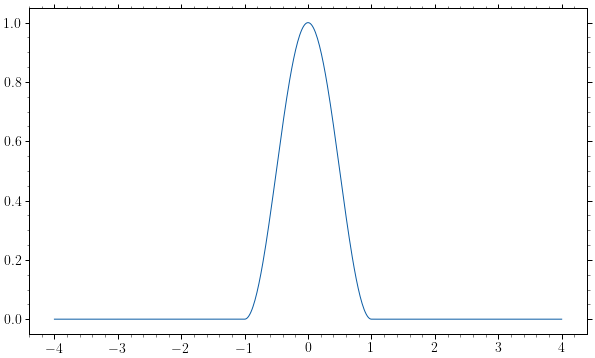

In [58]:
d = np.linspace(-4, 4, 512)
plt.plot(d, cosine(d));

In [59]:
N = 32
x, dx = np.linspace(-1, 1, N, retstep=True)
xs = x+0.5*dx
# random interface position
X = np.random.rand()*.1
V = 1
u0 = np.zeros_like(x)
dt = 1.
d = (x-X)/dx

p, u_n, f =  update(d, u0, V, dx, 1, cosine)
print("Interface at X: %.2f" % X)
print(r"L inf: %.3e" % np.max(np.abs(u_n -  V)))

Jacobi solver:
	res0: 3.030e-02
 	res: 3.004e-12
 	iter: 2840
Interface at X: 0.09
L inf: 1.446e-11


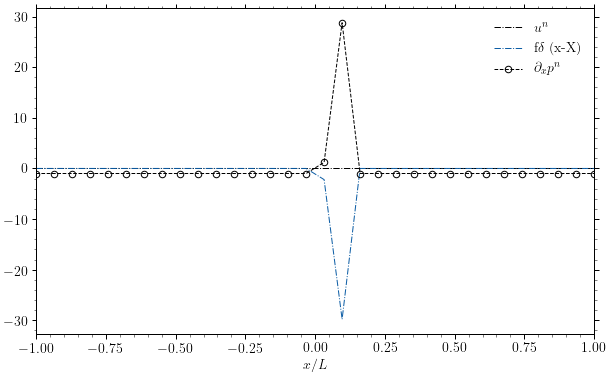

In [67]:
plt.plot(x, u0, '-.k', lw=1, label=r"$u^n$")
plt.plot(x, cosine(d)*f, '-.', lw=1, label=r"f$\delta$ (x-X)")
plt.plot(x, ns.grad(p, dx), '--ok',  lw=1, label=r"$\partial_x p^n$")
# plt.plot(x, u_n, '-m', lw=1, label=r"$u^{n+1}$")
# ns.draw_piston(plt, X, 0.015, 1)
plt.xlim(-1,1)#; plt.ylim(-2,2)
plt.xlabel(r'$x/L$')
plt.legend();